In [1]:
#mounting the drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
import seaborn as sb

In [3]:
data = pd.read_csv('/content/drive/MyDrive/files/data.csv')
data.head()

<ipython-input-3-384aeb11efaf>:1: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/files/data.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
df = data.copy()

In [5]:
df.shape

(855969, 73)

<ipython-input-6-a45f1b47fd46>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)


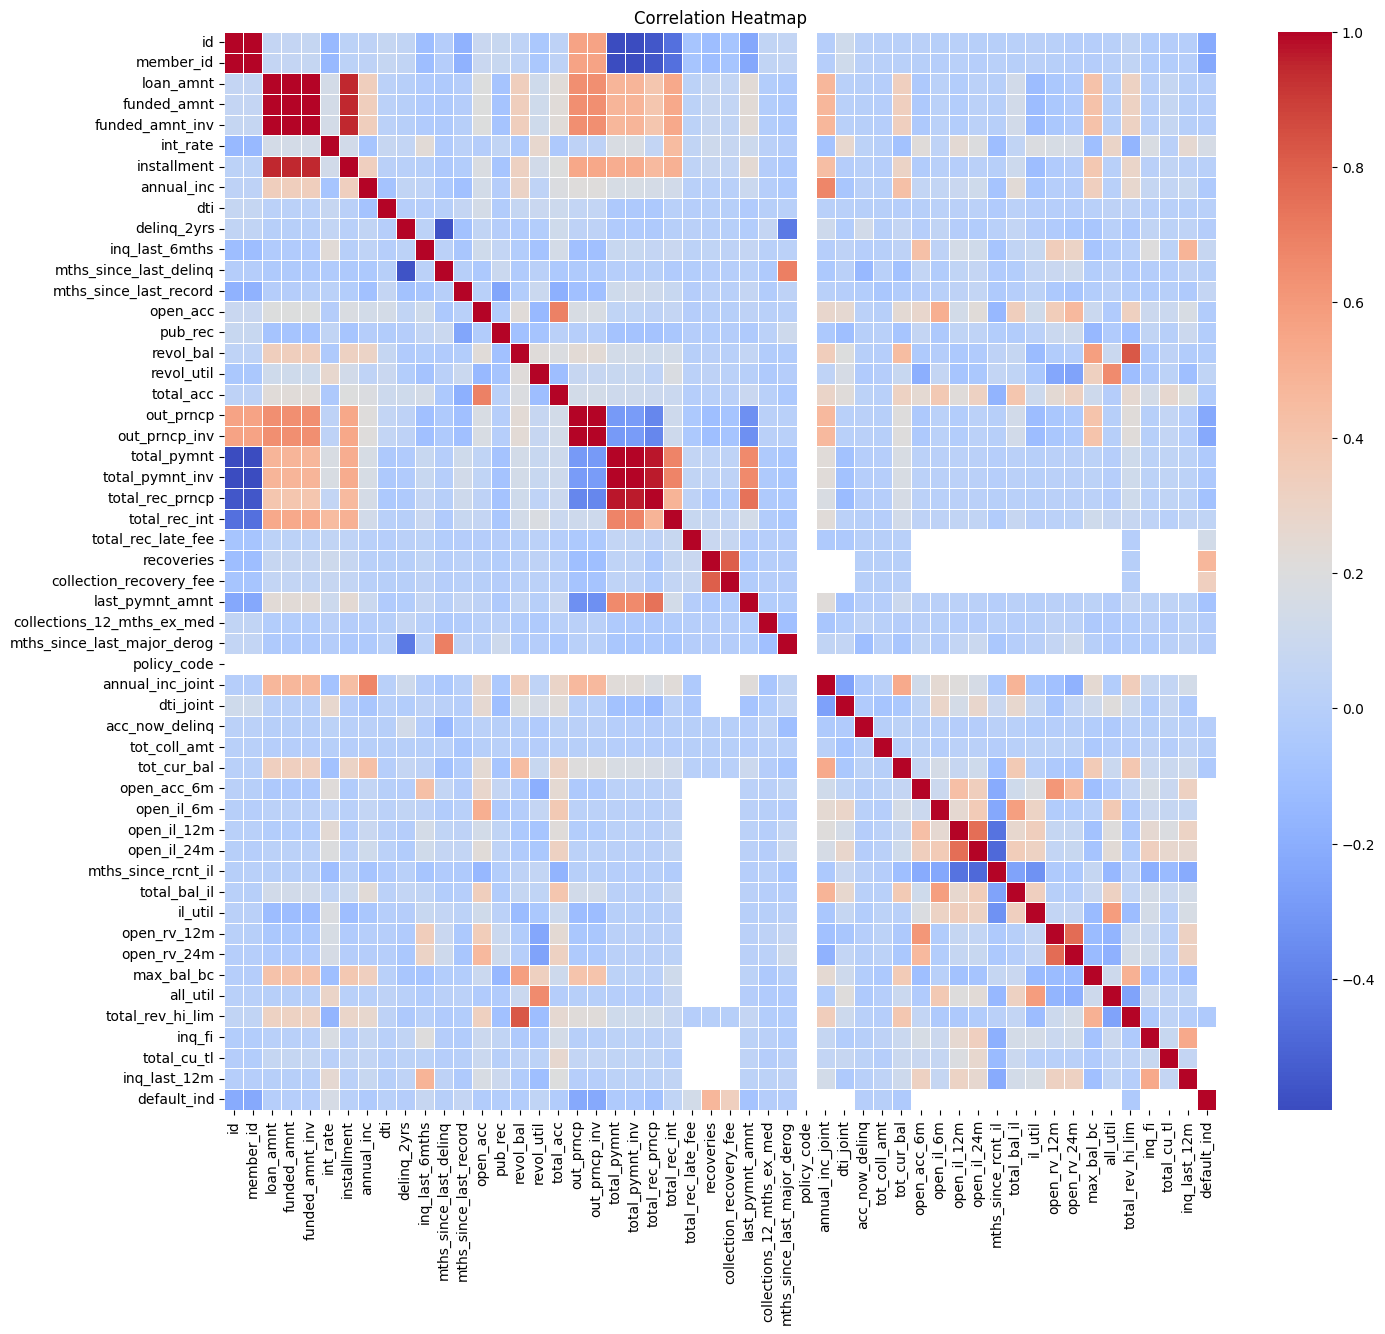

In [6]:
# heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

FEATURE SELECTION

In [7]:
#finding columns with null values(more than 30%)

#no of rows
total_rows = len(df)

#no of null values in each column
null_counts = df.isnull().sum()

# % of null values in each column
null_percentages = (null_counts / total_rows) * 100

#dataframe for displaying
null_summary = pd.DataFrame({
    'Column Name': null_counts.index,
    'Null Values': null_counts.values,
    'Null Percentage': null_percentages.values
})

#columns with null % above threshhold(30%)
null_summary_above_30 = null_summary[null_summary['Null Percentage'] > 30]

#sorting in desc order
null_summary_above_30 = null_summary_above_30.sort_values(by='Null Percentage', ascending=False)

print(null_summary_above_30)

                    Column Name  Null Values  Null Percentage
51             annual_inc_joint       855527        99.948363
52                    dti_joint       855527        99.948363
53    verification_status_joint       855527        99.948363
63                      il_util       844360        98.643759
61           mths_since_rcnt_il       843035        98.488964
60                  open_il_24m       842681        98.447607
70                  total_cu_tl       842681        98.447607
69                       inq_fi       842681        98.447607
67                     all_util       842681        98.447607
66                   max_bal_bc       842681        98.447607
65                  open_rv_24m       842681        98.447607
64                  open_rv_12m       842681        98.447607
71                 inq_last_12m       842681        98.447607
62                 total_bal_il       842681        98.447607
59                  open_il_12m       842681        98.447607
58      

In [8]:
#dropping columns above 30% null values

columns_to_drop = null_summary_above_30['Column Name'].tolist()
df.drop(columns=columns_to_drop, inplace=True)

print(df.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'default_ind'],
      dtype='object')


In [9]:
#dropping some other columns. came to this conclusion after carefully examining tha data by ourselves

columns_to_drop = ['title', 'total_pymnt', 'addr_state', 'last_credit_pull_d', 'member_id', 'total_acc', 'recoveries', 'pymnt_plan', 'next_pymnt_d', 'policy_code', 'total_pymnt_inv', 'loan_amnt', 'funded_amnt_inv', 'initial_list_status', 'out_prncp_inv', 'collection_recovery_fee', 'zip_code', 'id', 'out_prncp', 'total_rev_hi_lim', 'last_pymnt_amnt', 'total_rec_int', 'total_rec_prncp', 'emp_title', 'earliest_cr_line', 'issue_d', 'last_pymnt_d']
df.drop(columns=columns_to_drop, inplace=True)

print(df.columns)
print(df.shape[1])

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_rec_late_fee',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'default_ind'],
      dtype='object')
25


Treating Columns with Missing Values

In [10]:
#finding columns with missing values out of the remaining columns

total_rows = len(df)
missing_counts = df.isnull().sum()
missing_percentages = (missing_counts / total_rows) * 100

missing_summary = pd.DataFrame({
    'Column Name': missing_counts.index,
    'Missing Values': missing_counts.values,
    'Missing Percentage': missing_percentages.values
})
columns_with_missing_values = missing_summary[missing_summary['Missing Values'] > 0]

print(columns_with_missing_values)

                   Column Name  Missing Values  Missing Percentage
6                   emp_length           43061            5.030673
17                  revol_util             446            0.052105
19  collections_12_mths_ex_med              56            0.006542
22                tot_coll_amt           67313            7.863953
23                 tot_cur_bal           67313            7.863953


In [11]:
#replace missing values in column 21 and 22 with median
numeric_columns = ['tot_coll_amt', 'tot_cur_bal']
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

In [12]:

#replacing missing values in column 6 with mode

percentage_of_emp_length = df['emp_length'].value_counts(normalize=True) * 100
print(percentage_of_emp_length)

mode_emp_length = df['emp_length'].mode().values[0]
df['emp_length'].fillna(mode_emp_length, inplace=True)

10+ years    34.701344
2 years       9.347429
< 1 year      8.315455
3 years       8.290237
1 year        6.747996
5 years       6.619691
4 years       6.229856
7 years       5.314747
8 years       5.218426
6 years       5.098486
9 years       4.116333
Name: emp_length, dtype: float64


In [13]:
#dropping rows with missing values in column 16 and 18
drop_columns = ['revol_util', 'collections_12_mths_ex_med']
df = df.dropna(subset=drop_columns)

In [14]:
df.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_rec_late_fee',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'default_ind'],
      dtype='object')

FEATURE ENCODING

In [15]:
# Replace 'other' and 'any' with 'others' in the 'home_ownership' column
df['home_ownership'] = df['home_ownership'].replace(['other', 'any'], 'others')

In [16]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
# encoding the State column
lb = LabelEncoder()
df['term'] = lb.fit_transform(df['term'])
df['grade'] = lb.fit_transform(df['grade'])
df['home_ownership'] = lb.fit_transform(df['home_ownership'])
df['verification_status'] = lb.fit_transform(df['verification_status'])
df['purpose'] = lb.fit_transform(df['purpose'])
df['application_type'] = lb.fit_transform(df['application_type'])
df['emp_length'] = lb.fit_transform(df['emp_length'])
df['sub_grade'] = lb.fit_transform(df['sub_grade'])

In [17]:
categorical_columns = df.select_dtypes(include=['object'])

# Print the list of categorical columns
print("Categorical Columns:")
print(categorical_columns.columns.tolist())

Categorical Columns:
[]


In [18]:
df.head(2)

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_rec_late_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,default_ind
0,5000,0,10.65,162.87,1,6,1,5,24000.0,2,...,0,13648,83.7,0.0,0.0,0,0,0.0,81008.5,0
1,2500,1,15.27,59.83,2,13,10,5,30000.0,1,...,0,1687,9.4,0.0,0.0,0,0,0.0,81008.5,1


TRAIN TEST SPLIT

In [19]:
# Splitting the data into train set (75%), validation set (10%) and test set (15%)
x = df.iloc[:,:38]
y = df['default_ind']

In [20]:
total_class_counts = y.value_counts()
print(total_class_counts)

0    809054
1     46413
Name: default_ind, dtype: int64


In [21]:
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the entire dataset
x_balanced, y_balanced = smote.fit_resample(x, y)

# Check the class distribution after balancing
balanced_class_counts = y_balanced.value_counts()
print("Balanced dataset class distribution:")
print(balanced_class_counts)


Balanced dataset class distribution:
0    809054
1    809054
Name: default_ind, dtype: int64


In [22]:
x = x_balanced
y = y_balanced

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_part, y_train, y_part = train_test_split(x,y,test_size = 0.25,random_state = 42)
# random_state to see data splitting is consistent
x_test, x_valid, y_test, y_valid = train_test_split(x_part,y_part,test_size = 0.15,random_state = 42)

In [24]:
# Shape of the data considered for the above 3
print(x_train.shape,x_test.shape,x_valid.shape)
print(y_train.shape,y_test.shape,y_valid.shape)

(1213581, 25) (343847, 25) (60680, 25)
(1213581,) (343847,) (60680,)


In [31]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Evaluation Function
def evaluate(model, model_name, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, x_valid=x_valid, y_valid=y_valid):
    print(f"Model performance for {model_name}")

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    y_valid_pred = model.predict(x_valid)

    # Confusion Matrix
    plt.figure(figsize=(5, 5))
    sb.heatmap(confusion_matrix(y_train, y_train_pred), annot=True)
    plt.title('Confusion Matrix (Train)')
    plt.show()

    plt.figure(figsize=(5, 5))
    sb.heatmap(confusion_matrix(y_test, y_test_pred), annot=True)
    plt.title('Confusion Matrix (Test)')
    plt.show()

    # Precision Score
    precision_score_train = precision_score(y_train, y_train_pred)
    precision_score_test = precision_score(y_test, y_test_pred)
    precision_score_valid = precision_score(y_valid, y_valid_pred)

    # Recall Score
    recall_score_train = recall_score(y_train, y_train_pred)
    recall_score_test = recall_score(y_test, y_test_pred)
    recall_score_valid = recall_score(y_valid, y_valid_pred)

    # F1 Score
    f1_score_train = f1_score(y_train, y_train_pred)
    f1_score_test = f1_score(y_test, y_test_pred)
    f1_score_valid = f1_score(y_valid, y_valid_pred)

    # Accuracy
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    accuracy_valid = accuracy_score(y_valid, y_valid_pred)

    print("Precision Score (Train):", precision_score_train)
    print("Precision Score (Test):", precision_score_test)
    print("Precision Score (Validation):", precision_score_valid)

    print("Recall Score (Train):", recall_score_train)
    print("Recall Score (Test):", recall_score_test)
    print("Recall Score (Validation):", recall_score_valid)

    print("F1 Score (Train):", f1_score_train)
    print("F1 Score (Test):", f1_score_test)
    print("F1 Score (Validation):", f1_score_valid)

    print("Accuracy (Train):", accuracy_train)
    print("Accuracy (Test):", accuracy_test)
    print("Accuracy (Validation):", accuracy_valid)

    return {
        "Model": model_name,
        "Precision (Train)": precision_score_train,
        "Precision (Test)": precision_score_test,
        "Precision (Validation)": precision_score_valid,
        "Recall (Train)": recall_score_train,
        "Recall (Test)": recall_score_test,
        "Recall (Validation)": recall_score_valid,
        "F1 Score (Train)": f1_score_train,
        "F1 Score (Test)": f1_score_test,
        "F1 Score (Validation)": f1_score_valid,
        "Accuracy (Train)": accuracy_train,
        "Accuracy (Test)": accuracy_test,
        "Accuracy (Validation)": accuracy_valid
    }




In [32]:
import warnings
warnings.filterwarnings(action = "ignore")

In [33]:
# Standardize the training set
train_scaler = StandardScaler().fit(x_train)
X_train_scaled = train_scaler.transform(x_train)

# Standardize the validation set using its own statistics
valid_scaler = StandardScaler().fit(x_train)
X_valid_scaled = valid_scaler.transform(x_valid)

# Standardize the test set using its own statistics
test_scaler = StandardScaler().fit(x_test)
X_test_scaled = test_scaler.transform(x_test)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [35]:
clf1 = LogisticRegression()
clf1.fit(x_train,y_train)

LogisticRegression()

In [36]:
from sklearn.linear_model import LogisticRegression

# Specify the hyperparameters for LogisticRegression
penalty = 'l2'  # You can use 'l1', 'l2', 'elasticnet', or None
dual = False
tol = 1e-4
C = 1.0
fit_intercept = True
intercept_scaling = 1
class_weight = None  # You can specify class weights if needed
random_state = None  # Set a random state if desired
solver = 'lbfgs'  # Choose the solver based on your dataset size and problem
max_iter = 100  # Set the maximum number of iterations

clf1 = LogisticRegression(
    penalty=penalty,
    dual=dual,
    tol=tol,
    C=C,
    fit_intercept=fit_intercept,
    intercept_scaling=intercept_scaling,
    class_weight=class_weight,
    random_state=random_state,
    solver=solver,
    max_iter=max_iter
)

# Fit the classifier to your training data
clf1.fit(x_train, y_train)


LogisticRegression()

Model performance for LogisticRegression()


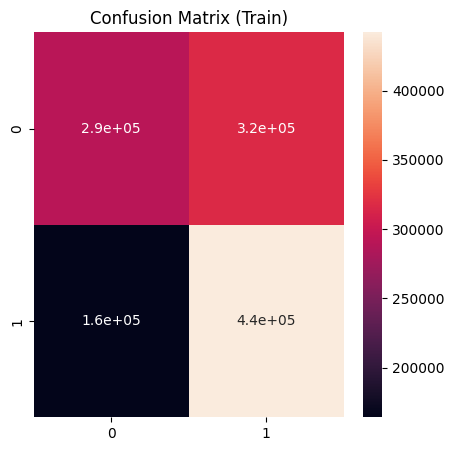

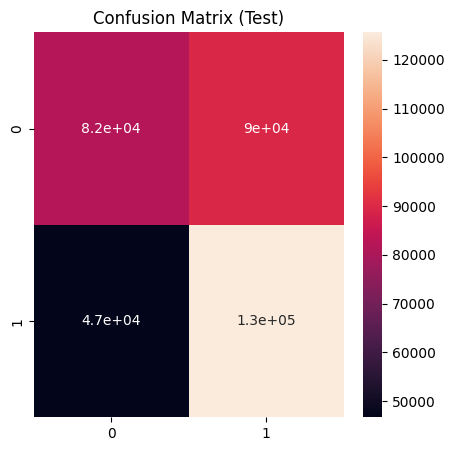

Precision Score (Train): 0.5824107049921406
Precision Score (Test): 0.5835794968974102
Precision Score (Validation): 0.5852429325143712
Recall Score (Train): 0.7291715466815349
Recall Score (Test): 0.7289885006788197
Recall Score (Validation): 0.7314480677120924
F1 Score (Train): 0.6475801483606274
F1 Score (Test): 0.648229643349103
F1 Score (Validation): 0.650228203969145
Accuracy (Train): 0.6035542744983647
Accuracy (Test): 0.6034050028064808
Accuracy (Validation): 0.6046967699406723


In [38]:
lr = evaluate(clf1,clf1)

In [39]:
clf3 = DecisionTreeClassifier(max_depth=10)
clf3.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=10)

Model performance for DecisionTreeClassifier(max_depth=10)


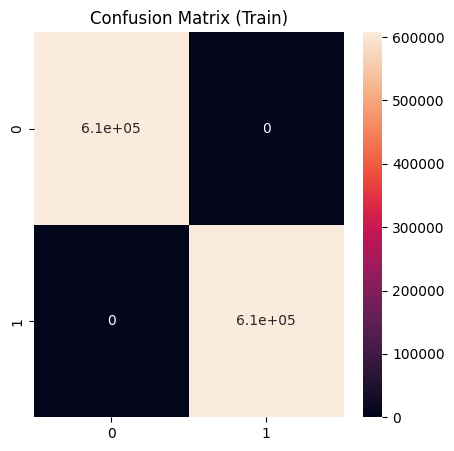

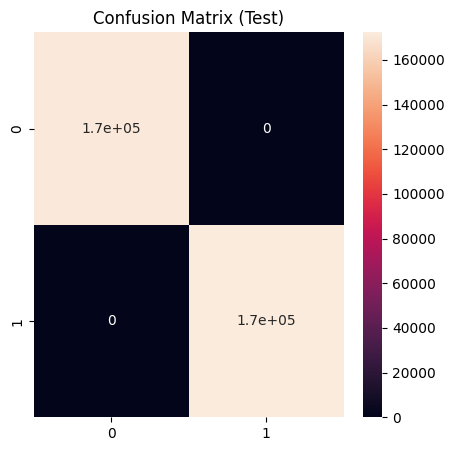

Precision Score (Train): 1.0
Precision Score (Test): 1.0
Precision Score (Validation): 1.0
Recall Score (Train): 1.0
Recall Score (Test): 1.0
Recall Score (Validation): 1.0
F1 Score (Train): 1.0
F1 Score (Test): 1.0
F1 Score (Validation): 1.0
Accuracy (Train): 1.0
Accuracy (Test): 1.0
Accuracy (Validation): 1.0


In [40]:
dt = evaluate(clf3,clf3)

In [43]:
clf4 = RandomForestClassifier()
clf4.fit(x_train,y_train)

RandomForestClassifier()

Model performance for RandomForestClassifier()


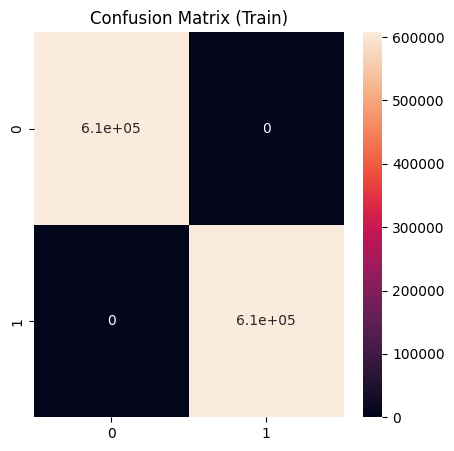

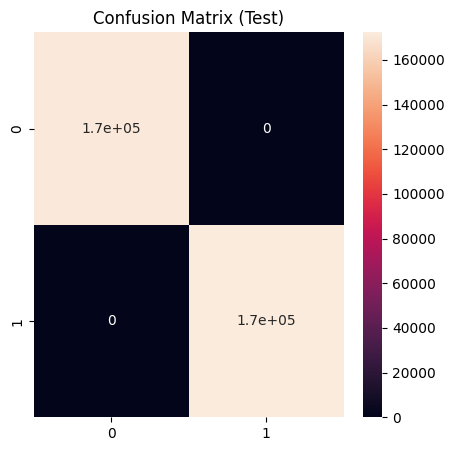

Precision Score (Train): 1.0
Precision Score (Test): 1.0
Precision Score (Validation): 1.0
Recall Score (Train): 1.0
Recall Score (Test): 1.0
Recall Score (Validation): 1.0
F1 Score (Train): 1.0
F1 Score (Test): 1.0
F1 Score (Validation): 1.0
Accuracy (Train): 1.0
Accuracy (Test): 1.0
Accuracy (Validation): 1.0


In [44]:
rf = evaluate(clf4,clf4)

In [45]:
# Specifying the hyperparameters for Naive Bayes
alpha = 1.0
fit_prior = True
class_prior = None

clf6 = MultinomialNB(
    alpha=alpha,
    fit_prior=fit_prior,
    class_prior=class_prior
)

# Fit the classifier to your training data
clf6.fit(x_train, y_train)


MultinomialNB()

Model performance for MultinomialNB()


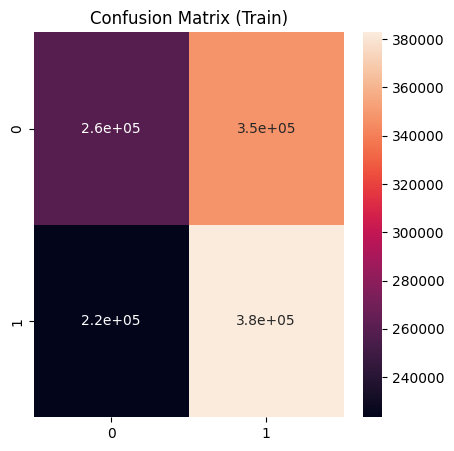

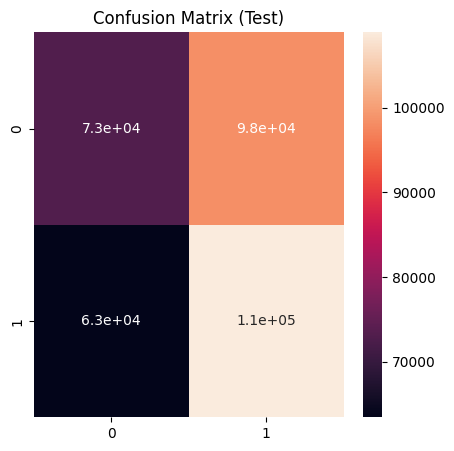

Precision Score (Train): 0.5239175652745087
Precision Score (Test): 0.5256181912084835
Precision Score (Validation): 0.5240106835277445
Recall Score (Train): 0.6315558532135517
Recall Score (Test): 0.6318012508847863
Recall Score (Validation): 0.630765697788859
F1 Score (Train): 0.5727231793587608
F1 Score (Test): 0.5738390398777451
F1 Score (Validation): 0.5724536278917438
Accuracy (Train): 0.5292790510068961
Accuracy (Test): 0.5296076452608283
Accuracy (Validation): 0.5266974291364536


In [46]:
mn = evaluate(clf6,clf6)

In [47]:
# Specifying the hyperparameters for XGBoost
n_estimators = 100
learning_rate = 0.1
max_depth = 3

clf5 = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth
)

# Fit the classifier to your training data
clf5.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Model performance for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


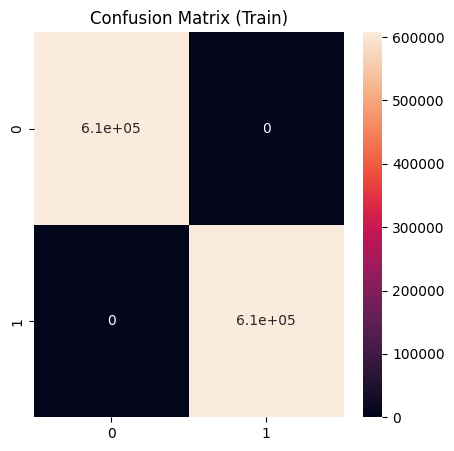

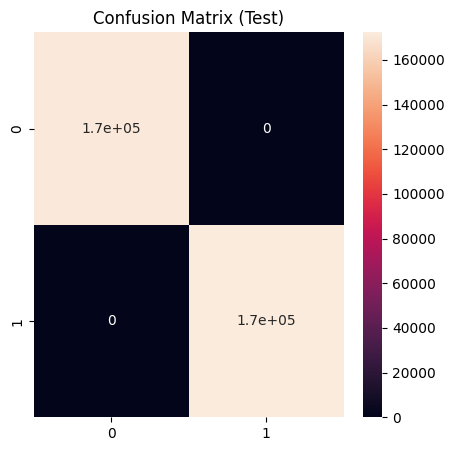

Precision Score (Train): 1.0
Precision Score (Test): 1.0
Precision Score (Validation): 1.0
Recall Score (Train): 1.0
Recall Score (Test): 1.0
Recall Score (Validation): 1.0
F1 Score (Train): 1.0
F1 Score (Test): 1.0
F1 Score (Validation): 1.0
Accuracy (Train): 1.0
Accuracy (Test): 1.0
Accuracy (Validation): 1.0


In [48]:
xg = evaluate(clf5,clf5)

In [49]:

# Specifying the hyperparameters for AdaBoost Classifier
n_estimators = 50
learning_rate = 1.0

clf9 = AdaBoostClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate
)

# Fit the classifier to your training data
clf9.fit(x_train, y_train)


AdaBoostClassifier()

Model performance for AdaBoostClassifier()


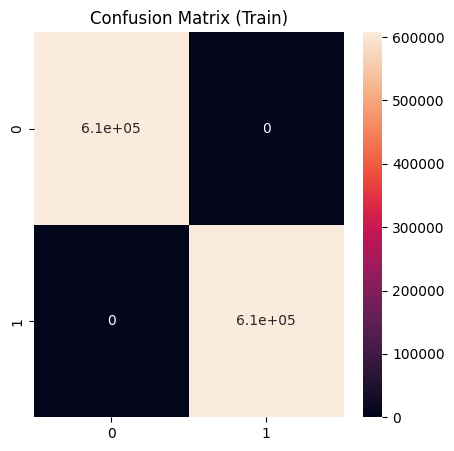

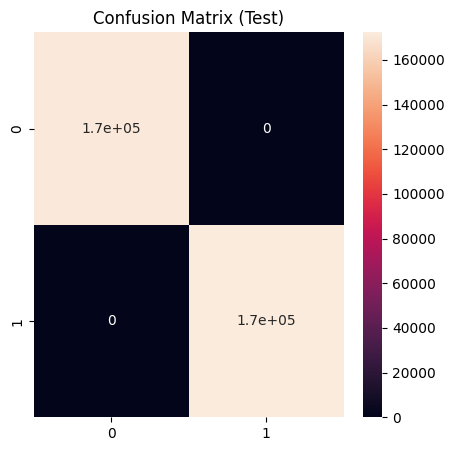

Precision Score (Train): 1.0
Precision Score (Test): 1.0
Precision Score (Validation): 1.0
Recall Score (Train): 1.0
Recall Score (Test): 1.0
Recall Score (Validation): 1.0
F1 Score (Train): 1.0
F1 Score (Test): 1.0
F1 Score (Validation): 1.0
Accuracy (Train): 1.0
Accuracy (Test): 1.0
Accuracy (Validation): 1.0


In [50]:
abc = evaluate(clf9,clf9)

In [52]:
# Create a list of dictionaries with model names and their evaluation metrics
model_results = [
    {
        'Model Name': 'Logistic Regression',
        'Precision (Train)': lr['Precision (Train)'],
        'Precision (Test)': lr['Precision (Test)'],
        'Precision (Validation)': lr['Precision (Validation)'],
        'Recall (Train)': lr['Recall (Train)'],
        'Recall (Test)': lr['Recall (Test)'],
        'Recall (Validation)': lr['Recall (Validation)'],
        'F1 Score (Train)': lr['F1 Score (Train)'],
        'F1 Score (Test)': lr['F1 Score (Test)'],
        'F1 Score (Validation)': lr['F1 Score (Validation)'],
        'Accuracy (Train)': lr['Accuracy (Train)'],
        'Accuracy (Test)': lr['Accuracy (Test)'],
        'Accuracy (Validation)': lr['Accuracy (Validation)'],
    },
    {
        'Model Name': 'Decision Tree Classifier',
        'Precision (Train)': dt['Precision (Train)'],
        'Precision (Test)': dt['Precision (Test)'],
        'Precision (Validation)': dt['Precision (Validation)'],
        'Recall (Train)': dt['Recall (Train)'],
        'Recall (Test)': dt['Recall (Test)'],
        'Recall (Validation)': dt['Recall (Validation)'],
        'F1 Score (Train)': dt['F1 Score (Train)'],
        'F1 Score (Test)': dt['F1 Score (Test)'],
        'F1 Score (Validation)': dt['F1 Score (Validation)'],
        'Accuracy (Train)': dt['Accuracy (Train)'],
        'Accuracy (Test)': dt['Accuracy (Test)'],
        'Accuracy (Validation)': dt['Accuracy (Validation)'],
    },
]



In [59]:
# Create dictionaries for the evaluation metrics of the models
rf_metrics = {
    'Model Name': 'Random Forest Classifier',
    'Precision (Train)': rf['Precision (Train)'],
    'Precision (Test)': rf['Precision (Test)'],
    'Precision (Validation)': rf['Precision (Validation)'],
    'Recall (Train)': rf['Recall (Train)'],
    'Recall (Test)': rf['Recall (Test)'],
    'Recall (Validation)': rf['Recall (Validation)'],
    'F1 Score (Train)': rf['F1 Score (Train)'],
    'F1 Score (Test)': rf['F1 Score (Test)'],
    'F1 Score (Validation)': rf['F1 Score (Validation)'],
    'Accuracy (Train)': rf['Accuracy (Train)'],
    'Accuracy (Test)': rf['Accuracy (Test)'],
    'Accuracy (Validation)': rf['Accuracy (Validation)'],
}

mn_metrics = {
    'Model Name': 'Multinomial Naive Bayes',
    'Precision (Train)': mn['Precision (Train)'],
    'Precision (Test)': mn['Precision (Test)'],
    'Precision (Validation)': mn['Precision (Validation)'],
    'Recall (Train)': mn['Recall (Train)'],
    'Recall (Test)': mn['Recall (Test)'],
    'Recall (Validation)': mn['Recall (Validation)'],
    'F1 Score (Train)': mn['F1 Score (Train)'],
    'F1 Score (Test)': mn['F1 Score (Test)'],
    'F1 Score (Validation)': mn['F1 Score (Validation)'],
    'Accuracy (Train)': mn['Accuracy (Train)'],
    'Accuracy (Test)': mn['Accuracy (Test)'],
    'Accuracy (Validation)': mn['Accuracy (Validation)'],
}

xg_metrics = {
    'Model Name': 'XGBoost Classifier',
    'Precision (Train)': xg['Precision (Train)'],
    'Precision (Test)': xg['Precision (Test)'],
    'Precision (Validation)': xg['Precision (Validation)'],
    'Recall (Train)': xg['Recall (Train)'],
    'Recall (Test)': xg['Recall (Test)'],
    'Recall (Validation)': xg['Recall (Validation)'],
    'F1 Score (Train)': xg['F1 Score (Train)'],
    'F1 Score (Test)': xg['F1 Score (Test)'],
    'F1 Score (Validation)': xg['F1 Score (Validation)'],
    'Accuracy (Train)': xg['Accuracy (Train)'],
    'Accuracy (Test)': xg['Accuracy (Test)'],
    'Accuracy (Validation)': xg['Accuracy (Validation)'],
}

abc_metrics = {
    'Model Name': 'AdaBoost Classifier',
    'Precision (Train)': abc['Precision (Train)'],
    'Precision (Test)': abc['Precision (Test)'],
    'Precision (Validation)': abc['Precision (Validation)'],
    'Recall (Train)': abc['Recall (Train)'],
    'Recall (Test)': abc['Recall (Test)'],
    'Recall (Validation)': abc['Recall (Validation)'],
    'F1 Score (Train)': abc['F1 Score (Train)'],
    'F1 Score (Test)': abc['F1 Score (Test)'],
    'F1 Score (Validation)': abc['F1 Score (Validation)'],
    'Accuracy (Train)': abc['Accuracy (Train)'],
    'Accuracy (Test)': abc['Accuracy (Test)'],
    'Accuracy (Validation)': abc['Accuracy (Validation)'],
}

# Append the dictionaries to the model_results list
model_results.append(rf_metrics)
model_results.append(mn_metrics)
model_results.append(xg_metrics)
model_results.append(abc_metrics)



In [57]:
# Create a DataFrame from the updated model_results list
model_performance = pd.DataFrame(model_results)




In [58]:
# Print the DataFrame
model_performance

,Model Name,Precision (Train),Precision (Test),Precision (Validation),Recall (Train),Recall (Test),Recall (Validation),F1 Score (Train),F1 Score (Test),F1 Score (Validation),Accuracy (Train),Accuracy (Test),Accuracy (Validation)
0,Logistic Regression,0.582411,0.583579,0.585243,0.729172,0.728989,0.731448,0.647580,0.648230,0.650228,0.603554,0.603405,0.604697
1,Decision Tree Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Random Forest Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Multinomial Naive Bayes,0.523918,0.525618,0.524011,0.631556,0.631801,0.630766,0.572723,0.573839,0.572454,0.529279,0.529608,0.526697
4,XGBoost Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,AdaBoost Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
